In [143]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
def f(x):
  return 3*x**2 - 4*x + 5

In [145]:
f(3.0)

20.0

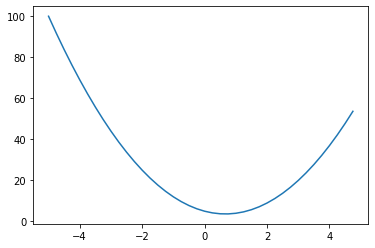

In [146]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [147]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [148]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) #lets us wrap other as a Value if it is not a Value( same line for multiply etc)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  # defining a power function a**b--> lets us do division by a * b^-1
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now cause setting it as value will lead to changes in the derivative expression"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self (accounting for issues created by 2 * a (Python reads as 2._mul(a) which is not waht we want))
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

# implimenting subtraction by simply negating the value to be subtracted and then calling the add function
  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
    # defining an exponential function e**x (complex numbers here we come) 
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [149]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [150]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

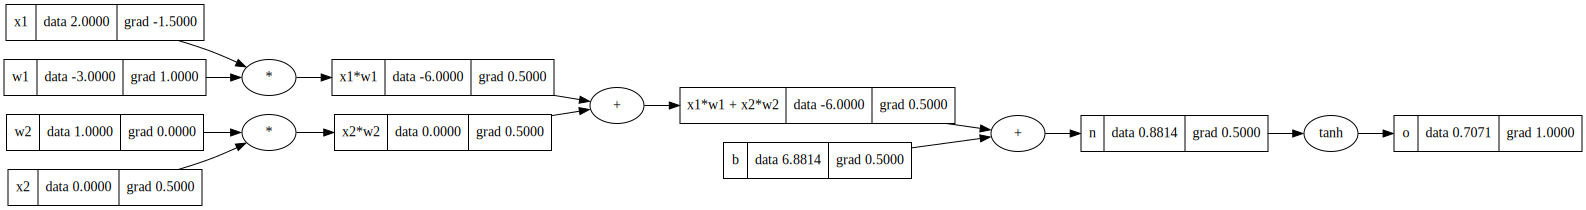

In [151]:
draw_dot(o)

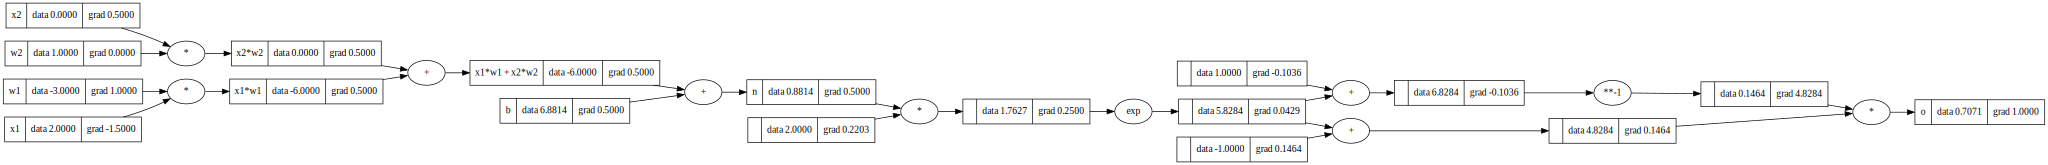

In [152]:
#breaking up the tanh as a exponential 
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [178]:
# now lets do the same thing but with the Pytorch API
#note Micrograd was a scalar value engine but Pytorch works with tensors(n dim array of scalars)
import torch


# using .double to have float64 instead of the base float32 datatype
#because these tensors are leaf nodes(inputs to the network) pytorch assumes they do not require a gradient,
#thus wwe have to manually tell it that all these nodes do need gradients

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # .item takes a single element from a tensor and returns that element discarding the tensor 
                     # o.item() and o.data.item() will produce the same result in Pytorch here

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [193]:
# time to build a neural net 

# creating a single neuron to be forwarded
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # random weight and bias
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #zip lets us create a 1-1 correspondence between inputs and wieghts by creating tuples of the two initial iterators
   
    # passing the raw activation thru a non linearity
    
    out = act.tanh()
    return out
  
# create a list of the params of the neurons (weights and biases)
#these a param scalars Pytorch also has a parameters on every NN module but it gives tensors instead of the scalars we have in this case
  def parameters(self):
    return self.w + [self.b]


# lets now define a layer of neurons as a list of neurons and how many neurons we want is defined by the input 

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # lets us output just a single output if that is the case instead of a list with one element
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


# now we are ready to define a Multi Layer Perceptron (MLP) where the neuron layers feed into each othee sequentially
# instead of taking a single nout (number of neurons in single layer) we take multiple nouts to get the sizes of all the layers\

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [194]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

#draw_dot(n(x))

Value(data=-0.7594357110927614)

In [195]:
# example data set w 4 examples xs
# binary classifier neural net
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets corresponding to each data set

#predict_ys = [n(x) for x in xs ]
#predict_ys
# this is giving us ugly numbers we want simple +- 1s 
# we need to tune the weights to better predict the desired targets {Time for the Loss number}
# the Loss is a single number that will evaluate the total performance of the neural net

In [196]:
#[(yout-ygt)**2 for ygt, yout in zip(ys,predict_ys)] # individual losses for each data set in xs
# we square it to get rid of the negative sign. np.abs should also do the trick

##Loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,predict_ys)) # final loss is just the sum of individual losses

#lets backpropagate
##Loss.backward()

#lets see what happened
##n.layers[0].neurons[0].w[0].grad

#draw_dot(Loss) # if you wanna see the humungous map

In [204]:
#lets write some code to operate on all the parameters of the neural net simultaneously
#we will also nudge the param a tiny amount based on the information from the gradient
#the main for loop (k in range (20)) is to determine total number of iterations of the nudges we will give to the params to mimimize our loss

for k in range(20):
  
  # forward pass
  predict_ys = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, predict_ys)) #mean squared error loss (theres all sorts of diff loss funcs)
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # always have this before backward pass otherwise your gradients from the last iteration will keep adding up to new ones (remember the +=)
  loss.backward()
  
  # update (gradient descent)
  for p in n.parameters():
    p.data += -0.1 * p.grad #-0.01 here because we want to minimize the loss
  # note that if the step is too large 1 instead of 0.1, we can overstep and accidently increase the loss (chaos)
 # if its too low you many need way too many steps to minimize the loss function. 
  print(k, loss.data)

predict_ys


0 0.0004563824822327038
1 0.0004547759641833388
2 0.0004531807247555665
3 0.0004515966457374894
4 0.0004500236105621616
5 0.0004484615042791136
6 0.00044691021352643304
7 0.0004453696265034112
8 0.00044383963294381435
9 0.0004423201240896271
10 0.00044081099266537777
11 0.00043931213285297295
12 0.00043782344026706266
13 0.0004363448119308476
14 0.00043487614625245053
15 0.0004334173430017103
16 0.00043196830328744195
17 0.00043052892953519015
18 0.00042909912546536
19 0.00042767879607186215


[Value(data=0.9861436679644014),
 Value(data=-0.9989846793797975),
 Value(data=-0.9987499806698604),
 Value(data=0.9847327987403199)]